## setup

In [1]:
import math
import scipy.stats as scs

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Import libraries
import numpy as np
import pandas as pd
import scipy
from scipy import special
from pathlib import Path

Nout = 100000  # number of out-of-sample scenarios
Nin = 5000     # number of in-sample scenarios
Ns = 5         # number of idiosyncratic scenarios for each systemic

C = 8          # number of credit states

# Read and parse instrument data
instr_data = np.array(pd.read_csv('instrum_data.csv', header=None))
instr_id = instr_data[:, 0]     # ID
driver = instr_data[:, 1]       # credit driver
beta = instr_data[:, 2]         # beta (sensitivity to credit driver)
recov_rate = instr_data[:, 3]   # expected recovery rate
value = instr_data[:, 4]        # value
prob = instr_data[:, 5:(5 + C)] # credit-state migration probabilities (default to AAA)
exposure = instr_data[:, 5 + C:5 + 2 * C]  # credit-state migration exposures (default to AAA)
retn = instr_data[:, 5 + 2 * C] # market returns

K = instr_data.shape[0]         # number of CPs

# Read matrix of correlations for credit drivers
rho = np.array(pd.read_csv('credit_driver_corr.csv', sep='\t', header=None))
# Cholesky decomp of rho (for generating correlated Normal random numbers)
sqrt_rho = np.linalg.cholesky(rho)

print('======= Credit Risk Model with Credit-State Migrations =======')
print('============== Monte Carlo Scenario Generation ===============')
print(' ')
print(' ')
print(' Number of out-of-sample Monte Carlo scenarios = ' + str(Nout))
print(' Number of in-sample Monte Carlo scenarios = ' + str(Nin))
print(' Number of counterparties = ' + str(K))
print(' ')

# Find credit-state for each counterparty
# 8 = AAA, 7 = AA, 6 = A, 5 = BBB, 4 = BB, 3 = B, 2 = CCC, 1 = default
CS = np.argmax(prob, axis=1) + 1

# Account for default recoveries
exposure[:, 0] = (1 - recov_rate) * exposure[:, 0]

# Compute credit-state boundaries
CS_Bdry = scipy.special.ndtri((np.cumsum(prob[:, 0:C - 1], 1)))


======= Credit Risk Model with Credit-State Migrations =======
============== Monte Carlo Scenario Generation ===============
 
 
 Number of out-of-sample Monte Carlo scenarios = 100000
 Number of in-sample Monte Carlo scenarios = 5000
 Number of counterparties = 100
 


## outofsample loss matrix

creditworthiness index w_j = \beta_j y_j(k) + \sigma_j z_j

- y_j(k): Y_sys: systemic credit driver factor
- z_j: Z_idio: idio risk factor
- beta_j: beta: sensitivity to systemic risk
- sigma_j

In [3]:
filename_save_out = 'Losses_out'
if Path(filename_save_out+'.npz').is_file():
    Losses_out = scipy.sparse.load_npz(filename_save_out + '.npz')
else:
    # Generating Scenarios

    # -------- Insert your code here -------- #
    Losses_out = np.zeros((Nout, K))
    Y_sys = np.random.normal(0, 1, (Nout, rho.shape[0])) @ sqrt_rho.T  # Systemic risk factors, correlated (Nout * #dirvers)

    for s in range(1, Nout + 1):
        # -------- Insert your code here -------- #
        Z_idio = np.random.normal(0, 1, K)
        sigma_j = np.sqrt(1 - beta**2)
        W_j = beta * Y_sys[s-1, driver.astype(int)-1] + sigma_j * Z_idio # creditworthiness index

        CS_new = np.sum(W_j[:, np.newaxis] > CS_Bdry, axis=1) + 1 # new CS
        scenario_losses = np.choose(CS_new - 1, exposure.T) # -1 to convert from 1 to 0-based
        Losses_out[s-1, :] = scenario_losses

    np.save(filename_save_out + ".npz", Losses_out)

## outofsample var, cvar

In [4]:
# Normal approximation computed from out-of-sample scenarios
mu_l = np.mean(Losses_out, axis=0).reshape((K))
var_l = np.cov(Losses_out, rowvar=False) # Losses_out as a sparse matrix

# Compute portfolio weights
portf_v = sum(value)  # portfolio value
w0 = []
w0.append(value / portf_v)   # asset weights (portfolio 1)
w0.append(np.ones((K)) / K)  # asset weights (portfolio 2)
x0 = []
x0.append((portf_v / value) * w0[0])  # asset units (portfolio 1)
x0.append((portf_v / value) * w0[1])  # asset units (portfolio 2)

# Quantile levels (99%, 99.9%)
alphas = np.array([0.99, 0.999])

VaRout = np.zeros((2, alphas.size))
VaRinN = np.zeros((2, alphas.size))
CVaRout = np.zeros((2, alphas.size))
CVaRinN = np.zeros((2, alphas.size))

for portN in range(2):
    # Compute VaR and CVaR
    losses = Losses_out @ x0[portN] # 100000*1, Losses_out: (Nout, K)
    sorted_losses=np.sort(losses)

    for q in range(alphas.size):
        alf = alphas[q]
        idx = int(np.ceil(Nout * alf))
        N = Nout
        # -------- Insert your code here -------- #

        # non-normal:
        VaRout[portN, q] = sorted_losses[idx]
        CVaRout[portN, q] = (1 / (N * (1 - alf))) * (
            (idx - N * alf) * VaRout[portN, q] + np.sum(sorted_losses[idx + 1:]))#...

        # normal:
        VaRinN[portN, q] = np.mean(sorted_losses) + scs.norm.ppf(alf) * np.std(sorted_losses) #...
        CVaRinN[portN, q] = np.mean(sorted_losses) + (scs.norm.pdf(scs.norm.ppf(alf)) / (1 - alf)) * np.std(sorted_losses) #...

## 100 trials

In [5]:
# Perform 100 trials
N_trials = 100

VaRinMC1 = {}
VaRinMC2 = {}
VaRinN1 = {}
VaRinN2 = {}
CVaRinMC1 = {}
CVaRinMC2 = {}
CVaRinN1 = {}
CVaRinN2 = {}

for portN in range(2):
    for q in range(alphas.size):
        VaRinMC1[portN, q] = np.zeros(N_trials)
        VaRinMC2[portN, q] = np.zeros(N_trials)
        VaRinN1[portN, q] = np.zeros(N_trials)
        VaRinN2[portN, q] = np.zeros(N_trials)
        CVaRinMC1[portN, q] = np.zeros(N_trials)
        CVaRinMC2[portN, q] = np.zeros(N_trials)
        CVaRinN1[portN, q] = np.zeros(N_trials)
        CVaRinN2[portN, q] = np.zeros(N_trials)

# loss matrices
Losses_inMC1 = np.zeros((Nin, K))  # 5000 x K
Losses_inMC2 = np.zeros((Nin, K))

for tr in range(1, N_trials + 1):
    # Monte Carlo approximation 1 (1000*5, K)
    for s in range(1, np.int32(np.ceil(Nin / Ns) + 1)): # systemic scenarios: 1000
        Y_sys_MC1 = np.random.normal(0, 1, (1, rho.shape[0])) @ sqrt_rho.T # (1, #drivers)
        for si in range(1, Ns + 1): # idiosyncratic scenarios for each systemic: 5
            scenario_index = (s - 1) * Ns + (si - 1) #
            Z_idio = np.random.normal(0, 1, K)
            sigma_j = np.sqrt(1 - beta**2)
            W_j = beta * Y_sys_MC1[0, driver.astype(int)-1] + sigma_j * Z_idio # creditness
            CS_new = np.sum(W_j[:, np.newaxis] > CS_Bdry, axis=1) + 1
            scenario_losses = np.choose(CS_new - 1, exposure.T)
            Losses_inMC1[scenario_index, :] = scenario_losses

    # Monte Carlo approximation 2
    for s in range(1, Nin + 1): # systemic scenarios (1 idiosyncratic scenario for each systemic)
        Y_sys_MC2 = np.random.normal(0, 1, (1, rho.shape[0])) @ sqrt_rho.T
        Z_idio = np.random.normal(0, 1, K)
        sigma_j = np.sqrt(1 - beta**2)
        W_j = beta * Y_sys_MC2[0, driver.astype(int)-1] + sigma_j * Z_idio
        CS_new = np.sum(W_j[:, np.newaxis] > CS_Bdry, axis=1) + 1
        scenario_losses = np.choose(CS_new - 1, exposure.T)
        Losses_inMC2[s-1, :] = scenario_losses

    # Compute VaR and CVaR
    for portN in range(2):
        for q in range(alphas.size):
            alf = alphas[q]
            # -------- Insert your code here -------- #
            # Compute portfolio loss
            port_loss_inMC1 = np.sort(Losses_inMC1 @ x0[portN]) # ... per iter (for a given trial and portf): (K,1)
            port_loss_inMC2 = np.sort(Losses_inMC2 @ x0[portN])#...

            mu_MC1 = np.mean(Losses_inMC1, axis=0).reshape((K)) # mean loss across rows/scenarios
            # var_MC1 = np.cov(Losses_inMC1.toarray(), rowvar=False)
            var_MC1 = np.cov(Losses_inMC1, rowvar=False)
            mu_MC2 = np.mean(Losses_inMC2, axis=0).reshape((K))
            # var_MC2 = np.cov(Losses_inMC2.toarray(), rowvar=False)
            var_MC2 = np.cov(Losses_inMC2, rowvar=False)

            mu_p_MC1 = mu_MC1 @ x0[portN] #...portf mean loss i.e. weighted mean loss
            sigma_p_MC1 = np.std(port_loss_inMC1) #... portf sd loss
            mu_p_MC2 = mu_MC2 @ x0[portN] #...
            sigma_p_MC2 = np.std(port_loss_inMC2) #...

            # Compute VaR and CVaR for the current trial
            idx = int(math.ceil(Nin*alf))-1

            VaRinMC1[portN, q][tr - 1] = port_loss_inMC1[idx] #...
            VaRinMC2[portN, q][tr - 1] = port_loss_inMC2[idx] #...
            VaRinN1[portN, q][tr - 1] =  mu_p_MC1 + scs.norm.ppf(alf) * sigma_p_MC1#...
            VaRinN2[portN, q][tr - 1] =  mu_p_MC2 + scs.norm.ppf(alf) * sigma_p_MC2#...

            CVaRinMC1[portN, q][tr - 1] =  (1 / (Nin * (1 - alf))) * (
            (idx - Nin * alf) * port_loss_inMC1[idx] +
            np.sum(port_loss_inMC1[idx+1:]))#...

            CVaRinMC2[portN, q][tr - 1] =  (1 / (Nin * (1 - alf))) * (
            (idx - Nin * alf) * port_loss_inMC2[idx] +
            np.sum(port_loss_inMC2[idx+1:])) #...

            CVaRinN1[portN, q][tr - 1] =  mu_p_MC1 + (scs.norm.pdf(scs.norm.ppf(alf)) / (1 - alf)) * sigma_p_MC1#...
            CVaRinN2[portN, q][tr - 1] = mu_p_MC2 + (scs.norm.pdf(scs.norm.ppf(alf)) / (1 - alf)) * sigma_p_MC2 #...

## display values

In [6]:
for portN in range(2):
    print('\nPortfolio {}:\n'.format(portN + 1))
    for q in range(alphas.size):
        alf = alphas[q]
        print('Out-of-sample: VaR %4.1f%% = $%6.2f, CVaR %4.1f%% = $%6.2f' % (
        100 * alf, VaRout[portN, q], 100 * alf, CVaRout[portN, q]))
        print('In-sample MC1: VaR %4.1f%% = $%6.2f, CVaR %4.1f%% = $%6.2f' % (
        100 * alf, np.mean(VaRinMC1[portN, q]), 100 * alf, np.mean(CVaRinMC1[portN, q])))
        print('In-sample MC2: VaR %4.1f%% = $%6.2f, CVaR %4.1f%% = $%6.2f' % (
        100 * alf, np.mean(VaRinMC2[portN, q]), 100 * alf, np.mean(CVaRinMC2[portN, q])))
        print('In-sample No: VaR %4.1f%% = $%6.2f, CVaR %4.1f%% = $%6.2f' % (
        100 * alf, VaRinN[portN, q], 100 * alf, CVaRinN[portN, q]))
        print('In-sample N1: VaR %4.1f%% = $%6.2f, CVaR %4.1f%% = $%6.2f' % (
        100 * alf, np.mean(VaRinN1[portN, q]), 100 * alf, np.mean(CVaRinN1[portN, q])))
        print('In-sample N2: VaR %4.1f%% = $%6.2f, CVaR %4.1f%% = $%6.2f\n' % (
        100 * alf, np.mean(VaRinN2[portN, q]), 100 * alf, np.mean(CVaRinN2[portN, q])))


Portfolio 1:

Out-of-sample: VaR 99.0% = $37307652.38, CVaR 99.0% = $44537457.45
In-sample MC1: VaR 99.0% = $37174482.74, CVaR 99.0% = $43870772.20
In-sample MC2: VaR 99.0% = $37273024.03, CVaR 99.0% = $44150179.81
In-sample No: VaR 99.0% = $26140139.09, CVaR 99.0% = $29024341.98
In-sample N1: VaR 99.0% = $26210865.31, CVaR 99.0% = $29101688.97
In-sample N2: VaR 99.0% = $26238157.53, CVaR 99.0% = $29133917.05

Out-of-sample: VaR 99.9% = $53614437.10, CVaR 99.9% = $61095431.42
In-sample MC1: VaR 99.9% = $53795332.14, CVaR 99.9% = $50310911.98
In-sample MC2: VaR 99.9% = $53972584.37, CVaR 99.9% = $50741085.08
In-sample No: VaR 99.9% = $32641810.66, CVaR 99.9% = $34998238.19
In-sample N1: VaR 99.9% = $32727461.64, CVaR 99.9% = $35089298.41
In-sample N2: VaR 99.9% = $32765880.44, CVaR 99.9% = $35131749.85


Portfolio 2:

Out-of-sample: VaR 99.0% = $27390600.37, CVaR 99.0% = $33387852.10
In-sample MC1: VaR 99.0% = $27376298.35, CVaR 99.0% = $32629655.09
In-sample MC2: VaR 99.0% = $27431402

## plot

- var, cvar
- normal, non-normal
- 99%, 99.9%

In [7]:
def plot_loss_distribution(losses, values_non_normal, labels_non_normal, values_normal, labels_normal, title):
    # Set colors
    color_non_normal = "red"  # Non-normal distributions
    color_normal = "green"  # Normal distributions

    plt.figure(figsize=(12,6))

    # Plot loss distribution
    sns.histplot(losses, bins=100, kde=False, stat="count", color="blue", alpha=0.6)
    sns.kdeplot(losses, color="darkorange", linewidth=2)

    # Define annotation and line height
    max_freq = plt.ylim()[1]
    annotation_height = max_freq * 0.7
    line_height = max_freq * 0.75  # Shorter lines

    # Plot non-normal values (Red)
    for i in range(len(values_non_normal)):
        plt.vlines(values_non_normal[i], ymin=0, ymax=line_height, color=color_non_normal)
        plt.text(values_non_normal[i], annotation_height, labels_non_normal[i], color=color_non_normal, rotation=90, verticalalignment='bottom')

    # Plot normal values (Green)
    for i in range(len(values_normal)):
        plt.vlines(values_normal[i], ymin=0, ymax=line_height, color=color_normal)
        plt.text(values_normal[i], annotation_height, labels_normal[i], color=color_normal, rotation=90, verticalalignment='bottom')

    # Add labels
    plt.xlabel("Loss ($)")
    plt.ylabel("Frequency")
    plt.title(title)

    # Remove the legend
    plt.legend().remove()

    # Show the plot
    plt.show()

### MC1, portf1

<ipython-input-7-3a0ac8cc8a47>:33: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend().remove()


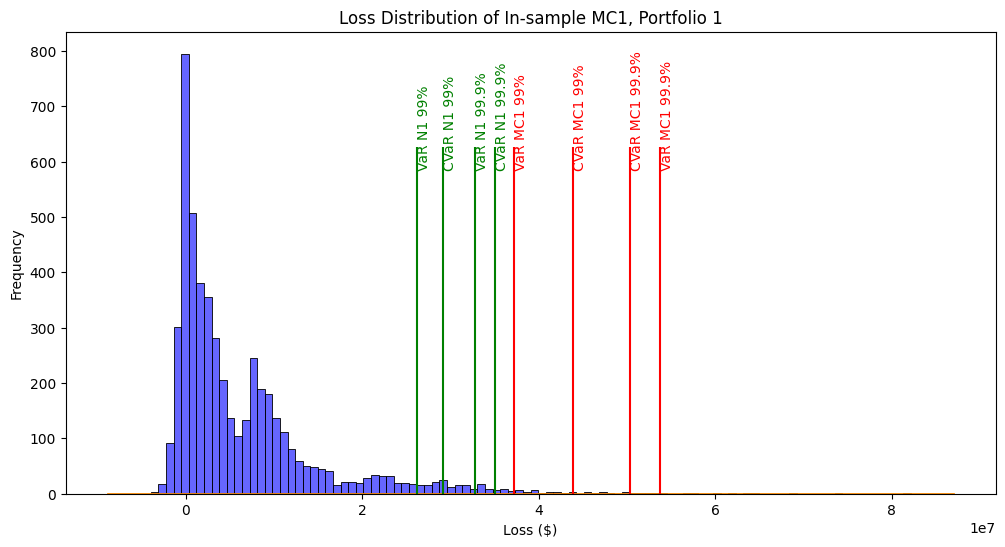

In [8]:
losses_port1_MC1 = Losses_inMC1 @ x0[0]

values_non_normal_MC1 = [np.mean(VaRinMC1[0, 0]), np.mean(CVaRinMC1[0, 0]),
                         np.mean(VaRinMC1[0, 1]), np.mean(CVaRinMC1[0, 1])]
labels_non_normal_MC1 = ["VaR MC1 99%", "CVaR MC1 99%", "VaR MC1 99.9%", "CVaR MC1 99.9%"]

values_normal_N1 = [np.mean(VaRinN1[0, 0]), np.mean(CVaRinN1[0, 0]),
                    np.mean(VaRinN1[0, 1]), np.mean(CVaRinN1[0, 1])]
labels_normal_N1 = ["VaR N1 99%", "CVaR N1 99%", "VaR N1 99.9%", "CVaR N1 99.9%"]

plot_loss_distribution(losses_port1_MC1, values_non_normal_MC1, labels_non_normal_MC1, values_normal_N1, labels_normal_N1, "Loss Distribution of In-sample MC1, Portfolio 1")

### MC1, portf2

<ipython-input-7-3a0ac8cc8a47>:33: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend().remove()


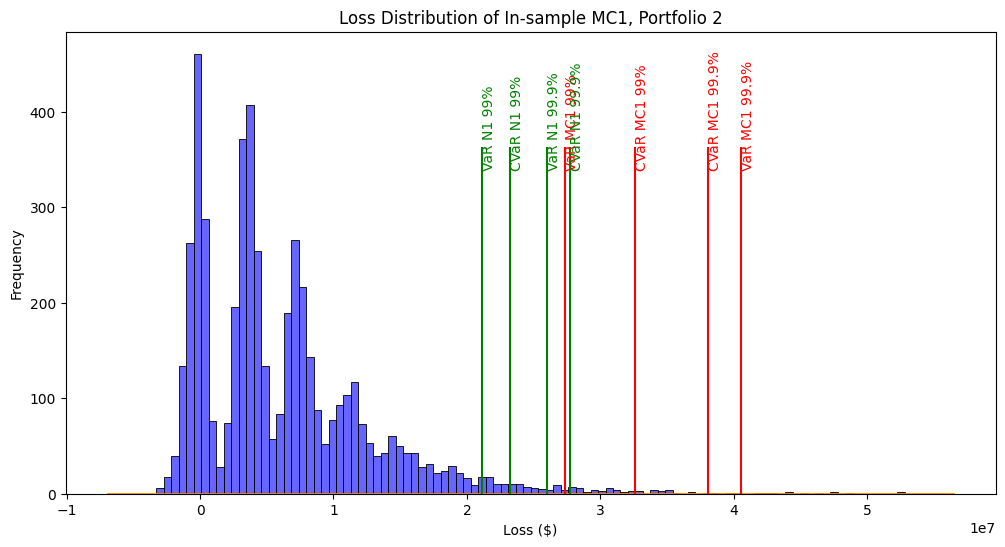

In [9]:
losses_port2_MC1 = Losses_inMC1 @ x0[1]

values_non_normal_MC1_port2 = [np.mean(VaRinMC1[1, 0]), np.mean(CVaRinMC1[1, 0]),
                               np.mean(VaRinMC1[1, 1]), np.mean(CVaRinMC1[1, 1])]
labels_non_normal_MC1_port2 = ["VaR MC1 99%", "CVaR MC1 99%", "VaR MC1 99.9%", "CVaR MC1 99.9%"]

values_normal_N1_port2 = [np.mean(VaRinN1[1, 0]), np.mean(CVaRinN1[1, 0]),
                          np.mean(VaRinN1[1, 1]), np.mean(CVaRinN1[1, 1])]
labels_normal_N1_port2 = ["VaR N1 99%", "CVaR N1 99%", "VaR N1 99.9%", "CVaR N1 99.9%"]

plot_loss_distribution(losses_port2_MC1, values_non_normal_MC1_port2, labels_non_normal_MC1_port2, values_normal_N1_port2, labels_normal_N1_port2, "Loss Distribution of In-sample MC1, Portfolio 2")

### MC2, portf1

<ipython-input-7-3a0ac8cc8a47>:33: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend().remove()


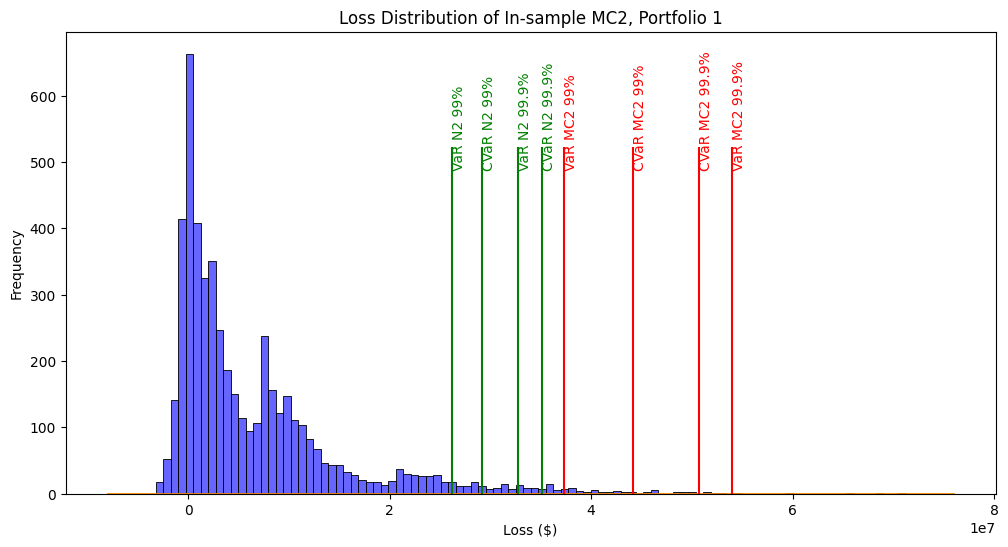

In [10]:
losses_port1_MC2 = np.dot(Losses_inMC2, x0[0])

values_non_normal_MC2_port1 = [np.mean(VaRinMC2[0, 0]), np.mean(CVaRinMC2[0, 0]),
                               np.mean(VaRinMC2[0, 1]), np.mean(CVaRinMC2[0, 1])]
labels_non_normal_MC2_port1 = ["VaR MC2 99%", "CVaR MC2 99%", "VaR MC2 99.9%", "CVaR MC2 99.9%"]

values_normal_N2_port1 = [np.mean(VaRinN2[0, 0]), np.mean(CVaRinN2[0, 0]),
                          np.mean(VaRinN2[0, 1]), np.mean(CVaRinN2[0, 1])]
labels_normal_N2_port1 = ["VaR N2 99%", "CVaR N2 99%", "VaR N2 99.9%", "CVaR N2 99.9%"]

plot_loss_distribution(losses_port1_MC2, values_non_normal_MC2_port1, labels_non_normal_MC2_port1, values_normal_N2_port1, labels_normal_N2_port1, "Loss Distribution of In-sample MC2, Portfolio 1")

### MC2, portf2

<ipython-input-7-3a0ac8cc8a47>:33: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend().remove()


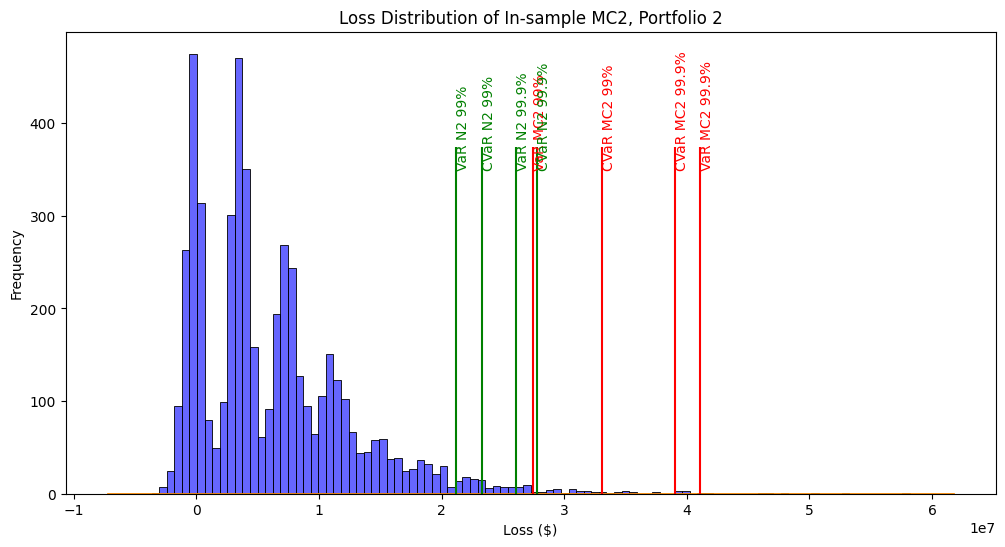

In [11]:
losses_port2_MC2 = np.dot(Losses_inMC2, x0[1])

values_non_normal_MC2_port2 = [np.mean(VaRinMC2[1, 0]), np.mean(CVaRinMC2[1, 0]),
                               np.mean(VaRinMC2[1, 1]), np.mean(CVaRinMC2[1, 1])]
labels_non_normal_MC2_port2 = ["VaR MC2 99%", "CVaR MC2 99%", "VaR MC2 99.9%", "CVaR MC2 99.9%"]

values_normal_N2_port2 = [np.mean(VaRinN2[1, 0]), np.mean(CVaRinN2[1, 0]),
                          np.mean(VaRinN2[1, 1]), np.mean(CVaRinN2[1, 1])]
labels_normal_N2_port2 = ["VaR N2 99%", "CVaR N2 99%", "VaR N2 99.9%", "CVaR N2 99.9%"]

plot_loss_distribution(losses_port2_MC2, values_non_normal_MC2_port2, labels_non_normal_MC2_port2, values_normal_N2_port2, labels_normal_N2_port2, "Loss Distribution of In-sample MC2, Portfolio 2")

### out of sample, portf1

<ipython-input-7-3a0ac8cc8a47>:33: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend().remove()


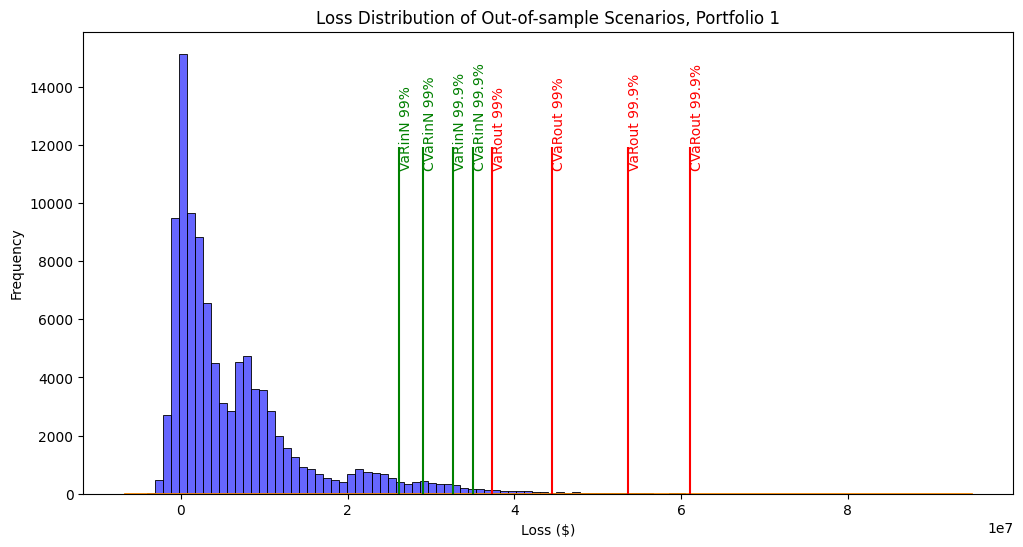

In [12]:
# Compute portfolio losses
losses_port1 = Losses_out @ x0[0]

# Define VaR and CVaR values
values_non_normal = [VaRout[0, 0], CVaRout[0, 0], VaRout[0, 1], CVaRout[0, 1]] # VaRout[portN, q]
labels_non_normal = ["VaRout 99%", "CVaRout 99%", "VaRout 99.9%", "CVaRout 99.9%"]

values_normal = [VaRinN[0, 0], CVaRinN[0, 0], VaRinN[0, 1], CVaRinN[0, 1]]
labels_normal = ["VaRinN 99%", "CVaRinN 99%", "VaRinN 99.9%", "CVaRinN 99.9%"]

# Call function to plot
plot_loss_distribution(losses_port1, values_non_normal, labels_non_normal, values_normal, labels_normal, "Loss Distribution of Out-of-sample Scenarios, Portfolio 1")

### out of sample portf2

<ipython-input-7-3a0ac8cc8a47>:33: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend().remove()


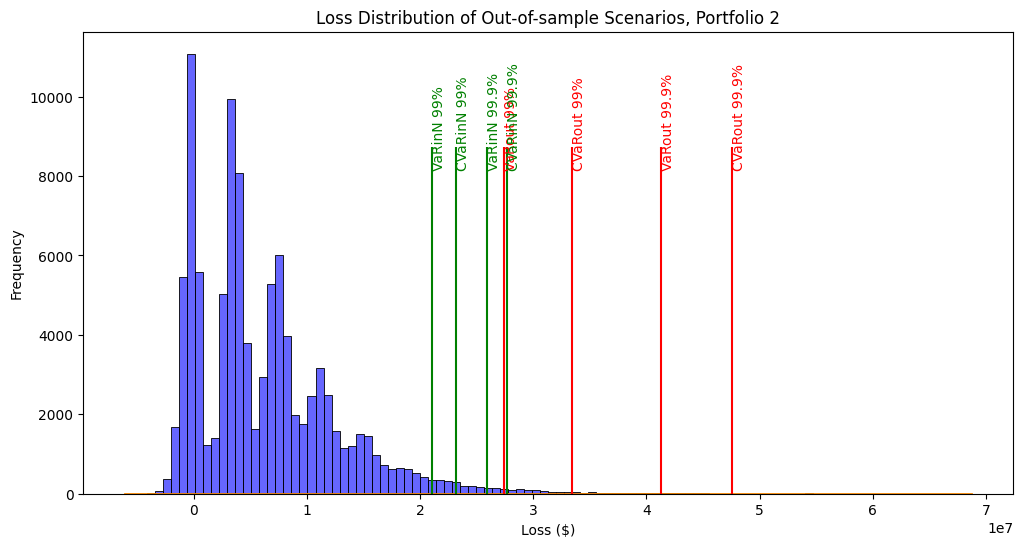

In [13]:
# Compute portfolio losses for Portfolio 2
losses_port2 = Losses_out @ x0[1]

# Define VaR and CVaR values for Portfolio 2
values_non_normal_port2 = [VaRout[1, 0], CVaRout[1, 0], VaRout[1, 1], CVaRout[1, 1]]
labels_non_normal_port2 = ["VaRout 99%", "CVaRout 99%", "VaRout 99.9%", "CVaRout 99.9%"]

values_normal_port2 = [VaRinN[1, 0], CVaRinN[1, 0], VaRinN[1, 1], CVaRinN[1, 1]]
labels_normal_port2 = ["VaRinN 99%", "CVaRinN 99%", "VaRinN 99.9%", "CVaRinN 99.9%"]

# Call function to plot Portfolio 2
plot_loss_distribution(losses_port2, values_non_normal_port2, labels_non_normal_port2, values_normal_port2, labels_normal_port2, "Loss Distribution of Out-of-sample Scenarios, Portfolio 2")

## err table

In [14]:
def compute_percent_error(estimated_value, true_value):
    return (estimated_value - true_value) / true_value * 100

### sampling error

In [15]:
# Define labels
error_labels_sample = [
    "99% VaR, MC1, Portfolio 1", "99% CVaR, MC1, Portfolio 1",
    "99% VaR, MC2, Portfolio 1", "99% CVaR, MC2, Portfolio 1",
    "99.9% VaR, MC1, Portfolio 1", "99.9% CVaR, MC1, Portfolio 1",
    "99.9% VaR, MC2, Portfolio 1", "99.9% CVaR, MC2, Portfolio 1",
    "99% VaR, MC1, Portfolio 2", "99% CVaR, MC1, Portfolio 2",
    "99% VaR, MC2, Portfolio 2", "99% CVaR, MC2, Portfolio 2",
    "99.9% VaR, MC1, Portfolio 2", "99.9% CVaR, MC1, Portfolio 2",
    "99.9% VaR, MC2, Portfolio 2", "99.9% CVaR, MC2, Portfolio 2"
]

sampling_error_values = np.array([
    compute_percent_error(np.mean(VaRinMC1[0, 0]), VaRout[0, 0]),  # 99% VaR, MC1, Portfolio 1， varRout[portN, q], VaRinMC1[portN, q][tr - 1]
    compute_percent_error(np.mean(CVaRinMC1[0, 0]), CVaRout[0, 0]),  # 99% CVaR, MC1, Portfolio 1
    compute_percent_error(np.mean(VaRinMC2[0, 0]), VaRout[0, 0]),  # 99% VaR, MC2, Portfolio 1
    compute_percent_error(np.mean(CVaRinMC2[0, 0]), CVaRout[0, 0]),  # 99% CVaR, MC2, Portfolio 1
    compute_percent_error(np.mean(VaRinMC1[0, 1]), VaRout[0, 1]),  # 99.9% VaR, MC1, Portfolio 1
    compute_percent_error(np.mean(CVaRinMC1[0, 1]), CVaRout[0, 1]),  # 99.9% CVaR, MC1, Portfolio 1
    compute_percent_error(np.mean(VaRinMC2[0, 1]), VaRout[0, 1]),  # 99.9% VaR, MC2, Portfolio 1
    compute_percent_error(np.mean(CVaRinMC2[0, 1]), CVaRout[0, 1]),  # 99.9% CVaR, MC2, Portfolio 1

    compute_percent_error(np.mean(VaRinMC1[1, 0]), VaRout[1, 0]),  # 99% VaR, MC1, Portfolio 2
    compute_percent_error(np.mean(CVaRinMC1[1, 0]), CVaRout[1, 0]),  # 99% CVaR, MC1, Portfolio 2
    compute_percent_error(np.mean(VaRinMC2[1, 0]), VaRout[1, 0]),  # 99% VaR, MC2, Portfolio 2
    compute_percent_error(np.mean(CVaRinMC2[1, 0]), CVaRout[1, 0]),  # 99% CVaR, MC2, Portfolio 2
    compute_percent_error(np.mean(VaRinMC1[1, 1]), VaRout[1, 1]),  # 99.9% VaR, MC1, Portfolio 2
    compute_percent_error(np.mean(CVaRinMC1[1, 1]), CVaRout[1, 1]),  # 99.9% CVaR, MC1, Portfolio 2
    compute_percent_error(np.mean(VaRinMC2[1, 1]), VaRout[1, 1]),  # 99.9% VaR, MC2, Portfolio 2
    compute_percent_error(np.mean(CVaRinMC2[1, 1]), CVaRout[1, 1])  # 99.9% CVaR, MC2, Portfolio 2
])
# Create dataframes
df_sampling_error = pd.DataFrame({"Sampling Error (% difference)": sampling_error_values}, index=error_labels_sample)
df_sampling_error

,Sampling Error (% difference)
"99% VaR, MC1, Portfolio 1",-0.356950
"99% CVaR, MC1, Portfolio 1",-1.496909
"99% VaR, MC2, Portfolio 1",-0.092818
"99% CVaR, MC2, Portfolio 1",-0.869555
"99.9% VaR, MC1, Portfolio 1",0.337400
"99.9% CVaR, MC1, Portfolio 1",-17.651925
"99.9% VaR, MC2, Portfolio 1",0.668005
"99.9% CVaR, MC2, Portfolio 1",-16.947824
"99% VaR, MC1, Portfolio 2",-0.052215
"99% CVaR, MC1, Portfolio 2",-2.270877


### modeling error: compared to outOfSample

In [16]:
error_labels_model = [
    "99% VaR, N1, Portfolio 1", "99% CVaR, N1, Portfolio 1",
    "99% VaR, N2, Portfolio 1", "99% CVaR, N2, Portfolio 1",
    "99.9% VaR, N1, Portfolio 1", "99.9% CVaR, N1, Portfolio 1",
    "99.9% VaR, N2, Portfolio 1", "99.9% CVaR, N2, Portfolio 1",
    "99% VaR, N1, Portfolio 2", "99% CVaR, N1, Portfolio 2",
    "99% VaR, N2, Portfolio 2", "99% CVaR, N2, Portfolio 2",
    "99.9% VaR, N1, Portfolio 2", "99.9% CVaR, N1, Portfolio 2",
    "99.9% VaR, N2, Portfolio 2", "99.9% CVaR, N2, Portfolio 2"
]

# Compute modeling errors for each portfolio and each alpha
modeling_error_values = np.array([
    compute_percent_error(np.mean(VaRinN1[0, 0]), VaRout[0, 0]),  # 99% VaR, N1, Portfolio 1, varRout[portN, q], VaRinMC1[portN, q][tr - 1]
    compute_percent_error(np.mean(CVaRinN1[0, 0]), CVaRout[0, 0]),  # 99% CVaR, N1, Portfolio 1
    compute_percent_error(np.mean(VaRinN2[0, 0]), VaRout[0, 0]),  # 99% VaR, N2, Portfolio 1
    compute_percent_error(np.mean(CVaRinN2[0, 0]), CVaRout[0, 0]),  # 99% CVaR, N2, Portfolio 1
    compute_percent_error(np.mean(VaRinN1[0, 1]), VaRout[0, 1]),  # 99.9% VaR, N1, Portfolio 1
    compute_percent_error(np.mean(CVaRinN1[0, 1]), CVaRout[0, 1]),  # 99.9% CVaR, N1, Portfolio 1
    compute_percent_error(np.mean(VaRinN2[0, 1]), VaRout[0, 1]),  # 99.9% VaR, N2, Portfolio 1
    compute_percent_error(np.mean(CVaRinN2[0, 1]), CVaRout[0, 1]),  # 99.9% CVaR, N2, Portfolio 1

    compute_percent_error(np.mean(VaRinN1[1, 0]), VaRout[1, 0]),  # 99% VaR, N1, Portfolio 2
    compute_percent_error(np.mean(CVaRinN1[1, 0]), CVaRout[1, 0]),  # 99% CVaR, N1, Portfolio 2
    compute_percent_error(np.mean(VaRinN2[1, 0]), VaRout[1, 0]),  # 99% VaR, N2, Portfolio 2
    compute_percent_error(np.mean(CVaRinN2[1, 0]), CVaRout[1, 0]),  # 99% CVaR, N2, Portfolio 2
    compute_percent_error(np.mean(VaRinN1[1, 1]), VaRout[1, 1]),  # 99.9% VaR, N1, Portfolio 2
    compute_percent_error(np.mean(CVaRinN1[1, 1]), CVaRout[1, 1]),  # 99.9% CVaR, N1, Portfolio 2
    compute_percent_error(np.mean(VaRinN2[1, 1]), VaRout[1, 1]),  # 99.9% VaR, N2, Portfolio 2
    compute_percent_error(np.mean(CVaRinN2[1, 1]), CVaRout[1, 1])  # 99.9% CVaR, N2, Portfolio 2
])

df_model_error = pd.DataFrame({"Model Error (% difference): Normal to outOfSample": modeling_error_values}, index=error_labels_model)
df_model_error


,Model Error (% difference): Normal to outOfSample
"99% VaR, N1, Portfolio 1",-29.743997
"99% CVaR, N1, Portfolio 1",-34.657947
"99% VaR, N2, Portfolio 1",-29.670843
"99% CVaR, N2, Portfolio 1",-34.585585
"99.9% VaR, N1, Portfolio 1",-38.957745
"99.9% CVaR, N1, Portfolio 1",-42.566412
"99.9% VaR, N2, Portfolio 1",-38.886087
"99.9% CVaR, N2, Portfolio 1",-42.496928
"99% VaR, N1, Portfolio 2",-22.985799
"99% CVaR, N1, Portfolio 2",-30.336842


### modeling error: compared MC to N

In [17]:
error_labels_model2 = [
    "99% VaR, N1, Portfolio 1 to MC1", "99% CVaR, N1, Portfolio 1 to MC1",
    "99% VaR, N2, Portfolio 1 to MC2", "99% CVaR, N2, Portfolio 1 to MC2",
    "99% VaR, No, Portfolio 1 to Out", "99% CVaR, No, Portfolio 1 to out", # added for No - out
    "99.9% VaR, N1, Portfolio 1 to MC1", "99.9% CVaR, N1, Portfolio 1 to MC1",
    "99.9% VaR, N2, Portfolio 1 to MC2", "99.9% CVaR, N2, Portfolio 1 to MC2",
    "99.9% VaR, No, Portfolio 1 to Out", "99.9% CVaR, No, Portfolio 1 to out", # added for No - out

    "99% VaR, N1, Portfolio 2 to MC1", "99% CVaR, N1, Portfolio 2 to MC1",
    "99% VaR, N2, Portfolio 2 to MC2", "99% CVaR, N2, Portfolio 2 to MC2",
    "99% VaR, No, Portfolio 2 to Out", "99% CVaR, No, Portfolio 2 to out", # added for No - out
    "99.9% VaR, N1, Portfolio 2 to MC1", "99.9% CVaR, N1, Portfolio 2 to MC1",
    "99.9% VaR, N2, Portfolio 2 to MC2", "99.9% CVaR, N2, Portfolio 2 to to MC2",
    "99.9% VaR, No, Portfolio 2 to Out", "99.9% CVaR, No, Portfolio 2 to out", # added for No - out
]

In [18]:
# Compute modeling errors for each portfolio and each alpha
modeling_error_values2 = np.array([
    # portf1
    compute_percent_error(np.mean(VaRinN1[0, 0]), np.mean(VaRinMC1[0, 0])),  # 99% varRout[portN, q], VaRinMC1[portN, q][tr - 1]
    compute_percent_error(np.mean(CVaRinN1[0, 0]), np.mean(CVaRinMC1[0, 0])),
    compute_percent_error(np.mean(VaRinN2[0, 0]), np.mean(VaRinMC2[0, 0])),
    compute_percent_error(np.mean(CVaRinN2[0, 0]), np.mean(CVaRinMC2[0, 0])),
    # No - out
    compute_percent_error(VaRinN[0,0],VaRout[0,0]),
    compute_percent_error(CVaRinN[0,0],CVaRout[0,0]),


    compute_percent_error(np.mean(VaRinN1[0, 1]), np.mean(VaRinMC1[0, 1])),  # 99.9%
    compute_percent_error(np.mean(CVaRinN1[0, 1]), np.mean(CVaRinMC1[0, 1])),
    compute_percent_error(np.mean(VaRinN2[0, 1]), np.mean(VaRinMC2[0, 1])),
    compute_percent_error(np.mean(CVaRinN2[0, 1]), np.mean(CVaRinMC2[0, 1])),
    # No - out
    compute_percent_error(VaRinN[0,1],VaRout[0,1]),
    compute_percent_error(CVaRinN[0,1],CVaRout[0,1]),


    # portf2
    compute_percent_error(np.mean(VaRinN1[1, 0]), np.mean(VaRinMC1[1, 0])),  # 99%
    compute_percent_error(np.mean(CVaRinN1[1, 0]), np.mean(CVaRinMC1[1, 0])),
    compute_percent_error(np.mean(VaRinN2[1, 0]), np.mean(VaRinMC2[1, 0])),
    compute_percent_error(np.mean(CVaRinN2[1, 0]), np.mean(CVaRinMC2[1, 0])),
    # No - out
    compute_percent_error(VaRinN[1,0],VaRout[1,0]),
    compute_percent_error(CVaRinN[1,0],CVaRout[1,0]),


    compute_percent_error(np.mean(VaRinN1[1, 1]), np.mean(VaRinMC1[1, 1])),  # 99.9%
    compute_percent_error(np.mean(CVaRinN1[1, 1]), np.mean(CVaRinMC1[1, 1])),
    compute_percent_error(np.mean(VaRinN2[1, 1]), np.mean(VaRinMC2[1, 1])),
    compute_percent_error(np.mean(CVaRinN2[1, 1]), np.mean(CVaRinMC2[1, 1])),
    # No - out
    compute_percent_error(VaRinN[1,0],VaRout[1,0]),
    compute_percent_error(CVaRinN[1,0],CVaRout[1,0]),

])

df_model_error2 = pd.DataFrame({"Model Error (% difference): Normal to corresponding non-normal": modeling_error_values2}, index=error_labels_model2)
df_model_error2


,Model Error (% difference): Normal to corresponding non-normal
"99% VaR, N1, Portfolio 1 to MC1",-29.492320
"99% CVaR, N1, Portfolio 1 to MC1",-33.664972
"99% VaR, N2, Portfolio 1 to MC2",-29.605504
"99% CVaR, N2, Portfolio 1 to MC2",-34.011782
"99% VaR, No, Portfolio 1 to Out",-29.933573
"99% CVaR, No, Portfolio 1 to out",-34.831614
"99.9% VaR, N1, Portfolio 1 to MC1",-39.163008
"99.9% CVaR, N1, Portfolio 1 to MC1",-30.255094
"99.9% VaR, N2, Portfolio 1 to MC2",-39.291622
"99.9% CVaR, N2, Portfolio 1 to MC2",-30.762715
